In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import statsmodels.formula.api as smf

plt.style.use("ggplot")

# Titration curves

Titration curves linking pH to CaCO3 (equivalent) concentrations for water with different levels of TOC.

Based on work by Atle Hindar (see e-mail from Øyvind K received 30.03.2023 at 12.37).

In [2]:
xl_path = r"../data/titration_curves_atle_hindar.xlsx"
df = pd.read_excel(xl_path)
df.head()

,TOC class (mg/l),CaCO3 (mg/l),pH
0,TOC ≤ 3,0.0,4.5
1,TOC ≤ 3,0.1,4.6
2,TOC ≤ 3,0.2,4.7
3,TOC ≤ 3,0.3,4.8
4,TOC ≤ 3,0.4,4.9


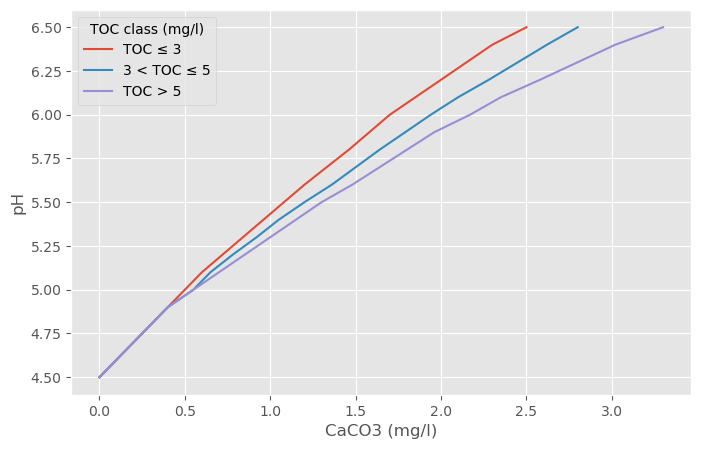

In [3]:
plt.figure(figsize=(8,5))
ax = sn.lineplot(x='CaCO3 (mg/l)', y='pH', hue='TOC class (mg/l)', data=df)

png_path = r"../docs/images/titration_curves.png"
plt.savefig(png_path, dpi=200)